# Data preprocessing

Man Ho Wong, University of Pittsburgh | April 23, 2022

*Jupyter notebooks are not always rendered properly on Github. Please [view this notebook here on nbviewer](https://nbviewer.org/github/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_preprocessing.ipynb) if that happens.*

##### Script header

In [1]:
# Python libraries and packages required
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pprint                    # For pretty printing
import pylangacq                 # For reading CHAT files

# For showing progress bar (optional)
#   This is useful for estimating the efficiency of the code.
from tqdm import tqdm

# Unpickle data
data_idx = pickle.load(open('../data/childes/data_idx_unprocessed.pkl', 'rb'))

# Pretty printing for better readability
# With this, you can print dict in compact format instead of one item
#   per line. Items will be in alphabetical order. Nested Dict will be printed 
#   with suitable indentation. It will also print Counter in descending order.
#   To use this, call cp.pprint()
cp = pprint.PrettyPrinter(compact=True, sort_dicts=True)

# Function to get all labels of a given variable (e.g. 'mot_edu')
def get_labels(var):
    labels_by_corpus = {}
    corpus_set = set(data_idx.corpus)
    for c in corpus_set:
        labels_by_corpus[c] = set(data_idx[var][data_idx.corpus==c])
    return labels_by_corpus

# 1 Overview

> Data processing pipeline:  
>[`data_curation.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_curation.ipynb)  
>`data_preprocessing.ipynb`  <-- You are here  
>[`exploratory_analysis.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/exploratory_analysis.ipynb)  
>[`vocabulary_analysis.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/vocabulary_analysis.ipynb)

This notebook is the second step of the data processing and analysis pipeline of the project. The goal here is to prepare the data curated by [`data_curation.ipynb`](https://github.com/Data-Science-for-Linguists-2022/Child-Vocab-Development/blob/main/code/data_curation.ipynb) for linguistic analysis later.

### Table of contents
1. [Overview](#1-overview)
    - [1.1 Quick recap](#11-quick-recap)
2. [Dataset integration](#2-dataset-integration)
    - [2.1 Merging `mot_edu` labels](#21-merging-motedu-labels)
    - [2.2 Merging `group` labels](#22-merging-group-labels)
    - [2.3 Merging `ses` labels](#23-merging-ses-labels)
3. [Data cleaning](#3-data-cleaning)
    - [3.1 Checking the `situation` labels](#31checking-the-situation-labels)
    - [3.2 Data cleaning strategy](#32-data-cleaning-strategy)
    - [3.3 Dropping data](#33-dropping-data)
4. [Matching files by child participants](#4-matching-files-by-child-participants)
5. [Summary](#5-summary)


## 1.1 Quick recap

- `data_idx` is a `DataFrame` created by [`data_curation.ipynb`](Data_Science/Child-Vocab-Development/code/data_curation.ipynb). It contains basic information about the CHAT files in the curated dataset. 
- Each entry in `data_idx` represents one CHAT file.
- Each file is specified by multiple *variables* (columns of `data_idx`), which can be a number, a string or a set of strings.
- For some variables with a set of discrete values (e.g., `ses` can be `MC`, `UC`, etc.), I will refer these values as *labels*. (e.g., `MC` is a label of the variable `ses`).

In [2]:
data_idx.head()

,file_path,corpus,year,participants,name,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
0,../data/childes/Bates/Free20/amy.cha,Bates,NaN,"{CHI, MOT}",Target_Child,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
1,../data/childes/Bates/Free20/betty.cha,Bates,NaN,"{CHI, MOT}",Betty,600,20.0,female,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
2,../data/childes/Bates/Free20/chuck.cha,Bates,NaN,"{CHI, MOT}",Chuck,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
3,../data/childes/Bates/Free20/doug.cha,Bates,NaN,"{CHI, MOT}",Doug,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"
4,../data/childes/Bates/Free20/ed.cha,Bates,NaN,"{CHI, MOT}",Ed,600,20.0,male,TD,MC,unspecified,unspecified,unspecified,"cross, toyplay, TD"


In [3]:
data_idx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2611 entries, 0 to 2610
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   file_path     2611 non-null   object 
 1   corpus        2611 non-null   object 
 2   year          1211 non-null   float64
 3   participants  2611 non-null   object 
 4   name          2611 non-null   object 
 5   age_d         2611 non-null   int64  
 6   age_m         2611 non-null   float64
 7   sex           2611 non-null   object 
 8   group         2611 non-null   object 
 9   ses           2611 non-null   object 
 10  mot_edu       2611 non-null   object 
 11  situation     2611 non-null   object 
 12  activities    2611 non-null   object 
 13  study_type    2611 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 285.7+ KB


---

# 2 Dataset integration

As mentioned in `data_curation.ipynb`, not all corpora use the same labels for some variables. For example, some corpora use school grade year to define mother's education (`mot_edu`), and some use level of education (e.g. 'college'):

In [4]:
mot_edu_labels = set(data_idx.mot_edu)
cp.pprint(mot_edu_labels)  # Print compactly

{'**', '10', '10 , GED', '102', '11', '11 , GED', '11+', '12', '12+', '13',
 '13+', '14', '15', '16', '6', '7', '8', '9', "Associate's_Degree", 'College',
 'College_Doctoral', 'College_J.D.', "College_Master's", 'High_School_Diploma',
 'MOT_1', 'MOT_2', 'MOT_3', 'Some_College', 'XX', 'almost 12', 'unspecified'}


Besides `mot_edu`, other variables with different labels used in different corpora include:  
- `group` (child's developmental group, e.g. typically developed)
- `ses` (Child's SES (socioeconomic status; same as mother's))
- `situation` Situation of recording (e.g. play session)
- `activities` (Activities during recording, e.g. Toy play)
- `study_type` type of study (e.g. longitudinal study)
    
I will change the labels for some of these variables, so that all corpora use the same set of labels.

Below is a list of homepages for all the corpora appeared in the curated dataset. You can find the basic information about the corpus, such as variable and label definitions, on its homepage and in the linked publications. I will check these pages when the variable labels are ambiguous.

In [5]:
corpus_homepages = {}
corpus_set = set(data_idx.corpus)

for c in corpus_set:
    url = "https://childes.talkbank.org/access/Eng-NA/" + c + ".html"
    corpus_homepages[c] = url

cp.pprint(corpus_homepages)

{'Bates': 'https://childes.talkbank.org/access/Eng-NA/Bates.html',
 'Bernstein': 'https://childes.talkbank.org/access/Eng-NA/Bernstein.html',
 'Brown': 'https://childes.talkbank.org/access/Eng-NA/Brown.html',
 'Clark': 'https://childes.talkbank.org/access/Eng-NA/Clark.html',
 'Demetras2': 'https://childes.talkbank.org/access/Eng-NA/Demetras2.html',
 'Gleason': 'https://childes.talkbank.org/access/Eng-NA/Gleason.html',
 'HSLLD': 'https://childes.talkbank.org/access/Eng-NA/HSLLD.html',
 'Hall': 'https://childes.talkbank.org/access/Eng-NA/Hall.html',
 'Hicks': 'https://childes.talkbank.org/access/Eng-NA/Hicks.html',
 'Nelson': 'https://childes.talkbank.org/access/Eng-NA/Nelson.html',
 'NewmanRatner': 'https://childes.talkbank.org/access/Eng-NA/NewmanRatner.html',
 'Post': 'https://childes.talkbank.org/access/Eng-NA/Post.html',
 'VanHouten': 'https://childes.talkbank.org/access/Eng-NA/VanHouten.html'}


## 2.1 Merging `mot_edu` labels

I will start with the 'simplest' variable, `mot_edu`.
First, let's find out which of the above labels each corpus uses for `mot_edu`. I will use a self-defined function, `get_labels()` (see header section of this notebook):

In [6]:
cp.pprint(get_labels('mot_edu'))  # get_labels() is defined in header section

{'Bates': {'unspecified'},
 'Bernstein': {'unspecified'},
 'Brown': {'unspecified'},
 'Clark': {'unspecified'},
 'Demetras2': {'unspecified'},
 'Gleason': {'unspecified'},
 'HSLLD': {'**', '10', '10 , GED', '102', '11', '11 , GED', '11+', '12', '12+',
           '13', '13+', '14', '15', '16', '6', '7', '8', '9', 'XX', 'almost 12',
           'unspecified'},
 'Hall': {'unspecified'},
 'Hicks': {'unspecified'},
 'Nelson': {'unspecified'},
 'NewmanRatner': {"Associate's_Degree", 'College', 'College_Doctoral',
                  'College_J.D.', "College_Master's", 'High_School_Diploma',
                  'Some_College', 'unspecified'},
 'Post': {'unspecified'},
 'VanHouten': {'unspecified', 'MOT_3', 'MOT_2', 'MOT_1'}}


--
  
As shown here, different classifications of education level are used in three corpora (HSLLD, NewmanRatner and VanHouten). HSLLD has a very detailed classification while VanHouten has only three classes. To merge all the labels across different corpora, I will use a less detailed classification without losing information needed for this project.

The labels used in HSLLD correspond to the school grade year the mother achieved. In the U.S. educational system, 'GED' is equivalent to completing grade 12, so I will merge these two classes as one. The labels '13' and beyond correspond to some post-secondary education (e.g. vocational training).

According to VanHouten's documentation, mother’s education is classified as MOT_1 (completed junior high), MOT_2 (completed high school) or MOT_3 (some post-secondary education).

I will merge the current labels into the following labels according to their common definitions: 

- `JH-`, `HS-`, `HS`, `HS+` for:
    - before completing junior high (before grade 9),
    - before completing high school (before GED or grade 12),
    - completed high school (GED or grade 12), and
    - some post-secondary education (after high school).

- `AD`, `UG-`, `UG` for:
    - associate's degree,
    - some undergraduate education, and
    - bachelor's degree.

- `MS`, `JD`, `DR` for:
    - master's degree,
    - juris doctor degree, and
    - doctoral degree.
    
I will map the current `mot_edu` labels to the above new labels with a `dictionary` and update `data_idx` with the new labels:

In [7]:
# Function to update 'mot_edu'
def update_mot_edu(data):
    label = data
    #' mot_edu' label mapping
    EDU_DICT = {
              'JH-':['6','7','8'],
              'HS-':['9','10','11','11+','almost 12','MOT_1'],
              'HS':['10 , GED','11 , GED','12','12+',
                    'High_School_Diploma','MOT_2'],
              'HS+':['13','13+','14','15','16','MOT_3'],
              'AD':["Associate's_Degree"],
              'UG-':['Some_College'],
              'UG':['College'], 
              'MS':["College_Master's"],
              'JD':['College_J.D.'],    
              'DR':['College_Doctoral'],
              'unspecified':['**','102','XX','unspecified']
               }
    
    for key in EDU_DICT:
        if data in EDU_DICT[key]:
            label = key
    return label

# Update 'mot_edu'
data_idx.mot_edu = data_idx.mot_edu.map(update_mot_edu)

# Check if update was successful
cp.pprint(get_labels('mot_edu'))

{'Bates': {'unspecified'},
 'Bernstein': {'unspecified'},
 'Brown': {'unspecified'},
 'Clark': {'unspecified'},
 'Demetras2': {'unspecified'},
 'Gleason': {'unspecified'},
 'HSLLD': {'HS+', 'HS-', 'JH-', 'unspecified', 'HS'},
 'Hall': {'unspecified'},
 'Hicks': {'unspecified'},
 'Nelson': {'unspecified'},
 'NewmanRatner': {'AD', 'MS', 'UG', 'JD', 'unspecified', 'HS', 'DR', 'UG-'},
 'Post': {'unspecified'},
 'VanHouten': {'unspecified', 'HS+', 'HS-', 'HS'}}


--

All labels for `mot_edu` were updated sucessfully!

## 2.2 Merging `group` labels

Below are the labels used in different corpora:

In [8]:
cp.pprint(get_labels('group'))

{'Bates': {'TD'},
 'Bernstein': {'unspecified', 'TD'},
 'Brown': {'unspecified', 'TD'},
 'Clark': {'TD'},
 'Demetras2': {'unspecified', 'TD'},
 'Gleason': {'unspecified', 'normal', 'typical', 'TD'},
 'HSLLD': {'unspecified'},
 'Hall': {'unspecified', 'White,UC', 'TD'},
 'Hicks': {'unspecified'},
 'Nelson': {'unspecified'},
 'NewmanRatner': {'TD'},
 'Post': {'TD'},
 'VanHouten': {'MOT_Adolescent', 'MOT_Adolescent_', 'MOT_Older', 'MOT_Older_',
               'MOT_adolescent', 'MOT_older', 'TD', 'unspecified'}}


--

As shown above, the `group` information of each file is not properly speficied in every corpus: 
- According the documentations of the corpora, all children in the dataset should be typically developed (`TD` in `group`). However, not all corpora put this information in the `group` field in the header of each file. Therefore, I will change the `unspecified` label to `TD`.
- in the Gleason corpus, labels `normal` and `typical` are used in additon to `TD`. I will change all labels to `TD`.
- In the Hall corpus, the labels for `group` and `ses` were switched in some files (e.g. `White,UC` should be a label for `ses`). I will switch them first and change all `group` labels to `TD`.
- In the VanHouten corpus, all children are `TD`, but it also contains data from adolescent mothers which I will not use for this project. I will first remove these files and change all labels to `TD`.

Let's take a quick look at the Hall corpus first:

In [9]:
labels = ['TD', 'typical', 'normal']
data_idx[['group','ses','study_type']][(data_idx.corpus=='Hall') & 
                                       ~(data_idx.group.isin(labels))]

,group,ses,study_type
1471,unspecified,"Black,WC","cross, everyday, AAE"
1472,unspecified,"Black,WC","cross, everyday, AAE"
1473,unspecified,"Black,WC","cross, everyday, AAE"
1474,unspecified,"Black,WC","cross, everyday, AAE"
1475,unspecified,"Black,WC","cross, everyday, AAE"
1476,unspecified,"Black,WC","cross, everyday, AAE"
1477,unspecified,"Black,WC","cross, everyday, AAE"
1478,unspecified,"Black,WC","cross, everyday, AAE"
1479,unspecified,"Black,WC","cross, everyday, AAE"
1480,unspecified,"Black,WC","cross, everyday, AAE"


As shown above in row 1482 and 1485, the label `White,UC` (i.e. upper class white) is actually a label for `ses`. I will copy the labels to `ses` of the corresponding rows:

In [10]:
data_idx.loc[data_idx.group=='White,UC','ses'] = 'White,UC'

# Check if ses labels were updated
data_idx.loc[[1482,1485],['group','ses','study_type']]


,group,ses,study_type
1482,"White,UC","White,UC","cross, everyday, TD"
1485,"White,UC","White,UC","cross, everyday, TD"


Note that the `group` labels are still `White,UC`, but I will change them to `TD` together with other corpora later.  
Next, I will drop the data collected from adolescent mothers in the VanHouten corpus:

In [11]:
drop_tags = ['MOT_Adolescent', 'MOT_Adolescent_', 'MOT_adolescent']
n_drop_group = len(data_idx[data_idx.group.isin(drop_tags)])
data_idx.drop(data_idx[data_idx.group.isin(drop_tags)].index, inplace=True)

# Check current labels
cp.pprint(get_labels('group'))

print(n_drop_group, 'files dropped!')

{'Bates': {'TD'},
 'Bernstein': {'unspecified', 'TD'},
 'Brown': {'unspecified', 'TD'},
 'Clark': {'TD'},
 'Demetras2': {'unspecified', 'TD'},
 'Gleason': {'unspecified', 'normal', 'typical', 'TD'},
 'HSLLD': {'unspecified'},
 'Hall': {'unspecified', 'White,UC', 'TD'},
 'Hicks': {'unspecified'},
 'Nelson': {'unspecified'},
 'NewmanRatner': {'TD'},
 'Post': {'TD'},
 'VanHouten': {'unspecified', 'MOT_Older_', 'MOT_Older', 'MOT_older', 'TD'}}
43 files dropped!


--

Finally, we are ready to change all the labels to `TD`!

In [12]:
# Change all 'group' label to 
data_idx['group'] = 'TD'

# Check updated labels
cp.pprint(get_labels('group'))

{'Bates': {'TD'},
 'Bernstein': {'TD'},
 'Brown': {'TD'},
 'Clark': {'TD'},
 'Demetras2': {'TD'},
 'Gleason': {'TD'},
 'HSLLD': {'TD'},
 'Hall': {'TD'},
 'Hicks': {'TD'},
 'Nelson': {'TD'},
 'NewmanRatner': {'TD'},
 'Post': {'TD'},
 'VanHouten': {'TD'}}


--

## 2.3 Merging `ses` labels

Below are the labels for `ses`:

In [13]:
cp.pprint(get_labels('ses'))

{'Bates': {'MC'},
 'Bernstein': {'unspecified', 'MC'},
 'Brown': {'MC', 'unspecified'},
 'Clark': {'UC'},
 'Demetras2': {'unspecified', 'WC'},
 'Gleason': {'MC', 'unspecified'},
 'HSLLD': {'unspecified'},
 'Hall': {'unspecified', 'Black,WC', 'White,UC', 'White,WC', 'Black,UC'},
 'Hicks': {'unspecified', 'LI'},
 'Nelson': {'unspecified', 'MC'},
 'NewmanRatner': {'unspecified'},
 'Post': {'WC'},
 'VanHouten': {'unspecified'}}


--

In these corpora, `WC`, `MC`, `UC` and `LI` mean 'working class', 'middle class', 'upper class' and 'low income' respectively. Different labels are used in different corpora:
- In the Hall corpus, each class of `WC` and `UC` is subdivided into two racial groups, `Black` and `White`. Since the primary goal of this project is to investigate the effects of SES and mother's education on vocabulary development, effects from other factors such as race will not be studied. I will merge the labels for different racial groups but same SES class together to get a larger sample size for each class. Although race may play an important role in children's language development, I hope that the balanced distribution of samples from different racial groups in the Hall Corpus will minimize the effects of race on my analysis.
- In the Hicks corpus, `LI` ('low income') is used instead of common SES class such as `WC`. Since the majority of low-come families presumably belong to the working class, I will change the label `LI` to `WC`. - Besides, the children in the subdirectories '1st', '2nd', and '5th' were considered coming from `MC` families. The children in the subdirectory 'del' were from lower class (presumably `WC`) families. I will assigned the missed labels accordingly.
- It is stated on the homepage of the Bernstein corpus that "the mothers were all college-educated women, who were native-born Americans with white-collar husband". Since all families in the study have similar background and some of the files were labeled `MC`, it is very likely that other files should also be labeled `MC`.
- The Brown corpus contains data from three children: Adam (`MC`), Sarah (`WC`) and Eve (`unspecified`). I will assigned the missed labels accordingly.
- All children in the Demetras2 corpus were from `WC` families.
- All children in the Gleason corpus were from `MC` families.
- All children in the HSLLD corpus were from low-income families. I will use the label `WC`.
- There is only one child in the Nelson corpus and she came from a `MC` family.

There are two corpora where no SES class information could be found:
- NewmanRatner corpus
- VanHouten corpus: Only Hollingshead index (a measurement of SES) is provided.

Let's begin cleaning up the `ses` labels:

In [14]:
# Function to merge 'ses' labels
def merge_ses(data):
    label = data
    # 'ses' label mapping
    SES_DICT = {'WC':['WC', 'Black,WC', 'White,WC', 'LI'],
                'UC':['UC', 'Black,UC', 'White,UC']}
    for key in SES_DICT:
        if data in SES_DICT[key]:
            label = key
    return label

# merge 'ses' labels in Hall and Hicks corpus: 
data_idx.ses = data_idx.ses.map(merge_ses)

# Update labels in Hicks corpus
for folder in ['1st','2nd','5th']:
    data_idx.loc[((data_idx.corpus=='Hicks') & 
                  (data_idx.file_path.map(lambda x: folder in x))),'ses'] = 'MC'
data_idx.loc[((data_idx.corpus=='Hicks') & 
              (data_idx.file_path.map(lambda x: 'del' in x))),'ses'] = 'WC'

# Update labels in Brown corpus
data_idx.loc[((data_idx.corpus=='Brown')&(data_idx.name=='Adam')),'ses']  = 'MC'
data_idx.loc[((data_idx.corpus=='Brown')&(data_idx.name=='Sarah')),'ses'] = 'WC'

# Update labels in other corpora
data_idx.loc[data_idx.corpus=='Bernstein','ses'] = 'MC'
data_idx.loc[data_idx.corpus=='Demetras2','ses'] = 'WC'
data_idx.loc[data_idx.corpus=='Gleason','ses']   = 'MC'
data_idx.loc[data_idx.corpus=='HSLLD','ses']     = 'WC'
data_idx.loc[data_idx.corpus=='Nelson','ses']    = 'MC'

# # Check updated labels
cp.pprint(get_labels('ses'))

{'Bates': {'MC'},
 'Bernstein': {'MC'},
 'Brown': {'MC', 'unspecified', 'WC'},
 'Clark': {'UC'},
 'Demetras2': {'WC'},
 'Gleason': {'MC'},
 'HSLLD': {'WC'},
 'Hall': {'unspecified', 'WC', 'UC'},
 'Hicks': {'MC', 'unspecified', 'WC'},
 'Nelson': {'MC'},
 'NewmanRatner': {'unspecified'},
 'Post': {'WC'},
 'VanHouten': {'unspecified'}}


---

# 3 Data cleaning

## 3.1 Checking the `situation` labels

The labels for different situations (e.g. play session, book reading, etc.) where the recordings were made could get very detailed in some files. For example:

In [15]:
print(data_idx.situation.sample(10, random_state=1).values)

['unspecified' 'unspecified'
 'Second home visit; book reading occurred in the living room with Mot sitting on chair , CHI kneeling next to her'
 'Home Visit 3' 'playing with toys' 'unspecified'
 'Sarah exits to shut off the tv as the tape begins'
 'Home Visit 1; took place in kitchen' 'Night' 'unspecified']



## 3.2 Data cleaning strategy

To clean up the data and remove the files that we don't need, it is not necessary to read each of the `situation` labels one by one. (Unless you have *plenty* of time!) We can just look for the keywords in these labels.

For example, I will remove the files that were recorded in less naturalistic situation (e.g. book reading and elicited data where the discourse was more or less 'planned') to get a fair comparison between different corpora. To do this, I will remove entries that contains the keywords "reading" and "elicit" in their `situation` labels. Note that sometimes such information may be stored in `activities` or `study_type` labels. Therefore, I will look for the keywords in *all* these three labels. Only the most common keywords will be considered as less common keywords are likely irrelvant to the classification of files.

Let's generate a list of keywords:

In [16]:
# for corpus in corpus_set:
#     for labels in get_labels('activities')[corpus]:
#         if 'reading' in labels:
#             print(corpus)

# Function to count keywords in labels
def count_keywords(var):  # 'var': the variable which the labels specify
    keywords = []            
    for f in data_idx[var]:
        keywords.extend(f.lower().split())  # get a list of keywords
    return Counter(keywords)

print('\nTop 20 situation keywords (word, count):')
cp.pprint(count_keywords('situation').most_common(50))

print('\nTop 20 activity keywords (word, count):')
cp.pprint(count_keywords('activities').most_common(50))

print('\nAll study type keywords (word, count):') #study type is not as detailed
cp.pprint(count_keywords('study_type').most_common())


Top 20 situation keywords (word, count):
[('unspecified', 1299), ('home', 658), ('visit', 561), ('the', 439),
 ('and', 423), ('on', 397), ('in', 339), (',', 315), ('chi', 277), ('mot', 242),
 ('with', 240), ('is', 196), ('place', 175), ('to', 164), ('living', 158),
 ('1', 144), ('3', 143), ('mother', 142), ('room', 140), ('kitchen', 139),
 ('took', 137), ('sitting', 136), ('of', 135), ('at', 126), ('floor', 123),
 ('sarah', 122), ('a', 121), ('first', 120), ('session', 111), ('visit;', 110),
 ('second', 101), ('child', 101), ('table', 93), ('are', 90), ('play', 82),
 ('couch', 79), ('toys', 76), ('playing', 74), ('her', 72), ('2', 71),
 ('sat', 66), ('next', 65), ('1;', 60), ('room;', 56), ('book', 49),
 ('playroom', 48), ('3;', 48), ('as', 47), ('toy', 47), ('(lab)', 46)]

Top 20 activity keywords (word, count):
[('unspecified', 1668), ('reading', 223), ('toy', 223), ('play', 213),
 ('report', 210), ('elicited', 208), ('book', 199), ('time', 153),
 ('meal', 150), ('the', 101), (',', 

--

From the lists of keywords, we can see that there are a few situations or activities that possibly have less natural child-mother interaction, such as book reading, elicited tasks and explanatory tasks (e.g. magnet task in the HSLLD corpus).

## 3.3 Dropping data

I will drop the files with labels containing the following keywords:  
`read, book, story, elicit, explanatory, magnet`

In addition, some files contain maternal interviews where the contents are adult speech instead of child-directed speech. Therefore, I will drop the files with labels containing the keyword `interview` too. Besides `situation`, `activities`, and `study_type`, I will also look for the keywords in `file_path` as some of these keywords may appear in the file path (e.g. folder name).

In [17]:
# Files with labels containing these words will be dropped:
#   (in regular expression format)
drop_keys = 'read|book|story|elicit|explanatory|magnet|interview'  

# Select files based and 'drop_keys' and get a list of indices
#  (keywords are case-insentive)
drop_index = data_idx[data_idx.situation.str.contains(drop_keys, case=False) |
                       data_idx.activities.str.contains(drop_keys, case=False) |
                       data_idx.study_type.str.contains(drop_keys, case=False) |
                       data_idx.file_path.str.contains(drop_keys, case=False)
                      ].index

# Drop the selected files
data_idx.drop(drop_index, inplace=True)

# Check keywords again after dropping
print('\nTop 20 situation keywords (word, count):')
cp.pprint(count_keywords('situation').most_common(50))

print('\nTop 20 activity keywords (word, count):')
cp.pprint(count_keywords('activities').most_common(50))

print('\nAll study type keywords (word, count):') #study type is not as detailed
cp.pprint(count_keywords('study_type').most_common())

print('\n{} entries were dropped!' .format(len(drop_index)))


Top 20 situation keywords (word, count):
[('unspecified', 858), ('home', 287), ('the', 272), ('visit', 268),
 ('and', 240), (',', 199), ('on', 180), ('in', 164), ('with', 153), ('is', 143),
 ('mother', 124), ('sarah', 101), ('floor', 96), ('child', 96), ('session', 94),
 ('of', 84), ('a', 83), ('to', 76), ('kitchen', 76), ('1', 76), ('chi', 75),
 ('play', 73), ('room', 73), ('mot', 73), ('at', 68), ('living', 67),
 ('playing', 66), ('3', 65), ('first', 64), ('toys', 64), ('are', 61),
 ('place', 60), ('sitting', 51), ('playroom', 48), ('took', 46), ('(lab)', 46),
 ('second', 45), ('freeplay', 44), ('table', 43), ('2', 43), ('meal', 43),
 ('before', 42), ('time', 42), ('toy', 41), ('her', 37), ('bed', 36),
 ('tape', 35), ('as', 35), ('visit;', 35), ('this', 30)]

Top 20 activity keywords (word, count):
[('unspecified', 1247), ('toy', 213), ('play', 205), ('time', 150),
 ('meal', 149), ('the', 31), ('and', 24), ('with', 23), ('mot', 17),
 ('chi', 16), ('playing', 13), ('is', 13), ('are',

---

# 4 Matching files by child participants

You may have noticed from the `study_type` variable that some files are labeled with `cross` or `long`. These labels refer to cross-sectional or longitudinal studies. Longitudinal studies are studies where repeated observations are made with the same participants over a period of time. In our currated dataset, some recordings were made with the same child participants during their development. Therefore, a child participant may have multiple files in a corpus.

We may try to identify all files associated with a child by matching the `name` variable (name of child participants). However, for privacy protection, these names are actually alias names. Files with the same name are not necessarily associated with the same child:

In [18]:
# Corpora containing files with child named 'Adam'
set(data_idx[data_idx.name=='Adam'].corpus)

{'Brown', 'VanHouten'}

Our favorite example, "Adam", appears in two corpora (Brown and VanHouten) - they can't be the same "Adam" because these studies were conducted separately. Therefore, we can't simply match the files by `name`. To match files associated with the same child, I will combine the corpus name with the name of the child and use the combine name as the child identity (`child_id`).

In [19]:
# Join corpus name and child name
child_id = data_idx[['corpus', 'name']].agg('_'.join, axis=1)

# Insert a new column for 'child_id'
data_idx.insert(5, 'child_id', child_id)
data_idx[data_idx.name=='Adam']

,file_path,corpus,year,participants,name,child_id,age_d,age_m,sex,group,ses,mot_edu,situation,activities,study_type
142,../data/childes/Brown/Adam/020304.cha,Brown,1962.0,"{URS, MOT, RIC, CHI, COL}",Adam,Brown_Adam,814,27.1,male,TD,MC,unspecified,unspecified,unspecified,"long, toyplay, TD"
143,../data/childes/Brown/Adam/020318.cha,Brown,1962.0,"{RIC, URS, MOT, CHI}",Adam,Brown_Adam,828,27.6,male,TD,MC,unspecified,unspecified,unspecified,"long, toyplay, TD"
144,../data/childes/Brown/Adam/020403.cha,Brown,1962.0,"{RIC, URS, MOT, CHI}",Adam,Brown_Adam,843,28.1,male,TD,MC,unspecified,unspecified,unspecified,"long, toyplay, TD"
145,../data/childes/Brown/Adam/020415.cha,Brown,NaN,"{URS, MOT, FAT, RIC, CHI}",Adam,Brown_Adam,855,28.5,male,TD,MC,unspecified,unspecified,unspecified,"long, toyplay, TD"
146,../data/childes/Brown/Adam/020430.cha,Brown,1962.0,"{RIC, URS, MOT, CHI}",Adam,Brown_Adam,870,29.0,male,TD,MC,unspecified,unspecified,unspecified,"long, toyplay, TD"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2544,../data/childes/VanHouten/Threes/teaching/nipt...,VanHouten,NaN,"{CHI, MOT, INV}",Adam,VanHouten_Adam,1210,40.3,male,TD,unspecified,unspecified,Teaching,unspecified,"cross, toyplay, TD"
2582,../data/childes/VanHouten/Twos/lunch/lundl.cha,VanHouten,NaN,"{CHI, MOT}",Adam,VanHouten_Adam,840,28.0,male,TD,unspecified,HS,Lunch. Child sits in high chair facing Mother ...,unspecified,"cross, meal, TD"
2585,../data/childes/VanHouten/Twos/lunch/nipl.cha,VanHouten,NaN,"{CHI, MOT}",Adam,VanHouten_Adam,840,28.0,male,TD,unspecified,HS,Lunch. Child is seated at the kitchen table wi...,unspecified,"cross, meal, TD"
2603,../data/childes/VanHouten/Twos/teaching/lundt.cha,VanHouten,NaN,"{CHI, MOT}",Adam,VanHouten_Adam,840,28.0,male,TD,unspecified,HS,Teaching. Mother and Child sitting on floor. F...,unspecified,"cross, toyplay, TD"


"Adam" comes in two flavors now: `Brown_Adam` and `VanHouten_Adam`. `child_id` will be helpful for distinguishing different children.

---

# 5 Summary

The following changes were made to the data in this notebook:

1. Similar `mot_edu` labels were merged and changed to custom labels.
2. All files are labeled as `TD` for `group`.
3. Similar `SES` labels were merged and changed to three classes: `WC` (working class), `MC` (middle class) and `UC` (upper class).
4. Unknown labels were marked as `unspecified`.
5. Entries collected from children of adolescent mothers were dropped.
6. Entries containing recordings from less naturalistic situations or maternal interviews (without CDS) were dropped.
7. A unique child ID was created for each entry.

After data preprocessing, 972 entries were dropped and there are 1639 remaining entries. The following figure shows how the data make-up looks like:

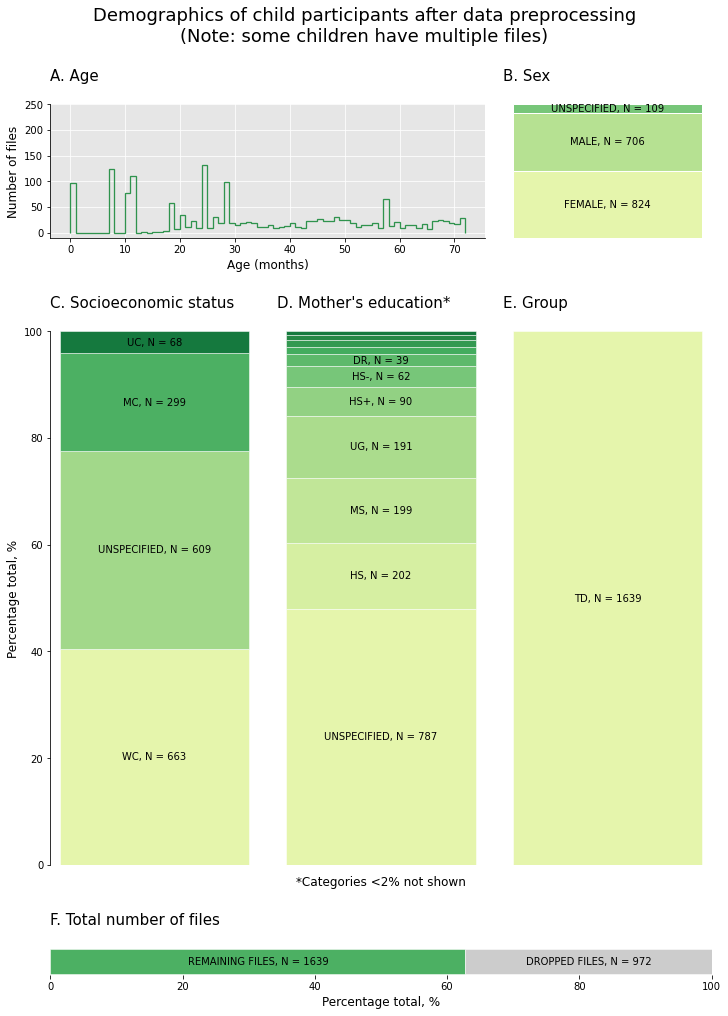

In [20]:
# Data for plotting
# Count files by 'sex', 'ses', 'mot_edu' or 'group'; count dropped files
sex_count = data_idx.groupby('sex').aggregate('count').file_path
ses_count = data_idx.groupby('ses').aggregate('count').file_path
mot_edu_count = data_idx.groupby('mot_edu').aggregate('count').file_path
group_count = data_idx.groupby('group').aggregate('count').file_path
total_count = pd.Series({'Remaining files':len(data_idx),
                         'Dropped files':len(drop_index)+n_drop_group})

# ==============================================================================
# Create a figure object

# Subplot dimension ratio
gs_kw = dict(width_ratios=[1,1,1], height_ratios=[1,4,0.2])

# Create a figure with 6 axes (i.e. 6 subplots), namely A, B, C, D, E, F
fig, ax = plt.subplot_mosaic([['A', 'A', 'B'],  # A spans across two grids
                              ['C', 'D', 'E'],
                              ['F', 'F', 'F']], # F spans across three grids                            
                              gridspec_kw=gs_kw, figsize=(10,14),
                              constrained_layout=True)
cmap = plt.cm.YlGn  # color map
accent_color = cmap(0.7)

# ==============================================================================
# Plotting

# ------------------------------------------------------------------------------
# Plot A
ax['A'].hist(data_idx.age_m, 72, histtype='step', color=accent_color, lw=1.3)

# ------------------------------------------------------------------------------
# Plot B
x = 'sex_pc'  # just a dummy xtick label required for bar chart
sex_count = sex_count.sort_values(ascending=False)  # sort by count
sex_pc = sex_count/sum(sex_count)*100  # get percentage from count
colors = cmap(np.linspace(0.2, 0.5, len(sex_pc)))  # get a set of colors from cmap
curr_sum = 0  # percentage sum (required for stacking bars)
for i, pc in enumerate(sex_pc):
    ax['B'].bar(x, pc, label=sex_pc.index[i], bottom=curr_sum,
                color=colors[i], edgecolor='w', linewidth=1)
    curr_sum = curr_sum + pc    
    # make label
    label = "{}, n = {}".format(sex_pc.index[i], sex_count[i]).upper()
    label_ypos = curr_sum - (pc/2)    
    ax['B'].text(0, label_ypos, label, ha="center", va="center")

# ------------------------------------------------------------------------------
# Plot C
x = 'ses_pc'  # just a dummy xtick label required for bar chart
ses_count = ses_count.sort_values(ascending=False)  # sort by count
ses_pc = ses_count/sum(ses_count)*100  # get percentage from count
colors = cmap(np.linspace(0.2, 0.8, len(ses_pc)))  # get a set of colors from cmap
curr_sum = 0  # percentage sum (required for stacking bars)
for i, pc in enumerate(ses_pc):
    ax['C'].bar(x, pc, label=ses_pc.index[i], bottom=curr_sum,
                color=colors[i], edgecolor='w', linewidth=0.5)
    curr_sum = curr_sum + pc    
    # make label
    if ses_pc.index[i] == '':
        label = "Unspecified, n = {}".format(ses_count[i]).upper()
    elif pc >= 1:  # only showing data with pc > 1
        label = "{}, n = {}".format(ses_pc.index[i], ses_count[i]).upper()
    else: label = ''    
    label_ypos = curr_sum - (pc/2)    
    ax['C'].text(0, label_ypos, label, ha="center", va="center")

# ------------------------------------------------------------------------------
# Plot D
x = 'edu_pc'  # just a dummy xtick label required for bar chart
mot_edu_count = mot_edu_count.sort_values(ascending=False)  # sort by count
edu_pc = mot_edu_count/sum(mot_edu_count)*100  # get percentage from count
colors = cmap(np.linspace(0.2, 0.8, len(edu_pc)))  # get a set of colors from cmap
curr_sum = 0  # percentage sum (required for stacking bars)
for i, pc in enumerate(edu_pc):
    ax['D'].bar(x, pc, label=edu_pc.index[i], bottom=curr_sum,
                color=colors[i], edgecolor='w', linewidth=0.5)
    curr_sum = curr_sum + pc    
    # make label
    if edu_pc.index[i] == '':
        label = "Unspecified, n = {}".format(mot_edu_count[i]).upper()
    elif pc >= 2:  # only showing data with pc > 2
        label = "{}, n = {}".format(edu_pc.index[i], mot_edu_count[i]).upper()
    else: label = ''    
    label_ypos = curr_sum - (pc/2)    
    ax['D'].text(0, label_ypos, label, ha="center", va="center")
    
# ------------------------------------------------------------------------------
# Plot E
x = 'group_pc'  # just a dummy xtick label required for bar chart
group_count = group_count.sort_values(ascending=False)  # sort by count
group_pc = group_count/sum(group_count)*100  # get percentage from count
colors = cmap(np.linspace(0.2, 0.8, len(group_pc)))  # get a set of colors from cmap
curr_sum = 0  # percentage sum (required for stacking bars)
for i, pc in enumerate(group_pc):
    ax['E'].bar(x, pc, label=group_pc.index[i], bottom=curr_sum,
                color=colors[i], edgecolor='w', linewidth=0.5)
    curr_sum = curr_sum + pc    
    # make label
    if group_pc.index[i] == '':
        label = "Unspecified, n = {}".format(group_count[i]).upper()
    elif pc >= 1:  # only showing data with pc > 1
        label = "{}, n = {}".format(group_pc.index[i], group_count[i]).upper()
    else: label = ''    
    label_ypos = curr_sum - (pc/2)    
    ax['E'].text(0, label_ypos, label, ha="center", va="center")

# ------------------------------------------------------------------------------
# Plot F
x = 'drop_pc'  # just a dummy xtick label required for bar chart
total_count = total_count.sort_values(ascending=False)  # sort by count
total_pc = total_count/sum(total_count)*100  # get percentage from count
colors = [plt.cm.YlGn(0.6), '0.8']
curr_sum = 0  # percentage sum (required for stacking bars)
for i, pc in enumerate(total_pc):
    ax['F'].barh(x, pc, label=total_pc.index[i], left=curr_sum,
                color=colors[i], edgecolor='w', linewidth=0.5)
    curr_sum = curr_sum + pc    
    # make label
    label = "{}, n = {}".format(total_count.index[i], total_count[i]).upper()  
    label_xpos = curr_sum - (pc/2)
    ax['F'].text(label_xpos, 0, label, ha="center", va="center", c='k')
    
    
# ------------------------------------------------------------------------------
# Formating

# Subplot A settings
ax['A'].set_xlabel('Age (months)', size=12)
ax['A'].set_ylabel('Number of files', size=12)
ax['A'].set_ylim([-10,250])
ax['A'].spines[['top', 'right']].set_visible(False)
ax['A'].grid(axis='both', color='w')
ax['A'].set_facecolor('0.9')

# Subplots B-E settings
for i in ['B','C','D','E']:
    ax[i].get_xaxis().set_visible(False)
    ax[i].set_ylabel('Percentage total, %', size=12)
    ax[i].set_ylim([0,100])
    ax[i].spines[['top','bottom', 'right']].set_visible(False)
    if i in ['B','D','E']:
        ax[i].get_yaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        ax[i].spines['left'].set_visible(False)        
ax['D'].text(0,-2,'*Categories <2% not shown', ha="center", va="top", size=12)

# Subplot F settings
ax['F'].get_yaxis().set_visible(False)
ax['F'].set_xlabel('Percentage total, %', size=12)
ax['F'].set_xlim([0,100])
ax['F'].spines[:].set_visible(False)

# Set subplot titles
ax['A'].set_title('\nA. Age\n', loc='left', size=15)
ax['B'].set_title('\nB. Sex\n', loc='left', size=15)
ax['C'].set_title('\nC. Socioeconomic status\n', loc='left', size=15)
ax['D'].set_title('\nD. Mother\'s education*\n', loc='left', size=15)
ax['E'].set_title('\nE. Group\n', loc = 'left', size=15)
ax['F'].set_title('\nF. Total number of files\n', loc='left', size=15)

# Set figure title
fig.suptitle('Demographics of child participants after data preprocessing\n(Note: some children have multiple files)', fontsize=18)

# Save figure
# plt.savefig('../reports/images/child_demgph_processed.svg', bbox_inches='tight', dpi=150)
plt.show()

# Saving the processed data

In [21]:
# f = open('../data/childes/data_idx_processed.pkl', 'wb')
# pickle.dump(data_idx, f, -1)
# f.close()